In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
import glob
warnings.filterwarnings('ignore')



def norm_plot(df):
    df = df.copy()
    df = (df - df.mean()) / df.std()
    return df

def add_moving_averages(df, moving_averages, columns):
    df = df.copy()
    for ma in moving_averages:
        for col in columns:
            new_col = f'{col}_ma{ma}'
            df[new_col] = df[col].rolling(window=ma).mean()
    # ffill na
    df.fillna(method='ffill', inplace=True)
    return df

from tabulate import tabulate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread


def create_dataset(data, look_back, target_col="spread_close", split_sizes=[0.6, 0.2, 0.2], drop_cols: list = []):
    data = data.copy().dropna()
    y = data[target_col]
    y_shifted = y.shift(-look_back)

    data["target"] = y_shifted
    data = data.dropna().drop(drop_cols, axis=1)
    train_size = int(len(data) * split_sizes[0])
    val_size = int(len(data) * split_sizes[1])
    test_size = len(data) - train_size - val_size

    print("\n------Dataset Information------")
    print(tabulate([
            ["Train", train_size, data.index[train_size].date()],
            ["Val", val_size, data.index[-val_size].date()],
            ["Test", test_size, data.index[-test_size].date()]],
        ["Set", "Size", "Date Cutoff"]))

    train_data = data.iloc[:train_size]
    val_data = data.iloc[train_size : train_size + val_size]
    test_data = data.iloc[-test_size:]
    return train_data, val_data, test_data


def prepare_dataset(train_data, val_data, test_data):
    X_train, y_train = train_data.drop(columns=["target"]), train_data["target"]
    X_val, y_val = val_data.drop(columns=["target"]), val_data["target"]
    X_test, y_test = test_data.drop(columns=["target"]), test_data["target"]

    return X_train, y_train, X_val, y_val, X_test, y_test



data_dir = '../data/'
price_history_dir = data_dir + 'price_history/'
sentiment_dir = data_dir + 'sentiments/'
ti_dir = data_dir + 'technical_indicators/'

# Load Ticker Pairs
tickers_list = [file.split('/')[-1].strip('.csv') for file in glob.glob(price_history_dir + '*.csv')]
pairs_df = pd.read_csv(data_dir + 'ranked_pairs_snp.csv')
pairs = pairs_df[['ticker_0', 'ticker_1']].values
unique_pairs = pairs_df[['ticker_0', 'ticker_1']].drop_duplicates('ticker_0', keep='first').drop_duplicates('ticker_1', keep='first')

# Load Ticker History, Sentiment, and Technical Indicators
class TickerData:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history = pd.read_csv(price_history_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.sentiment = pd.read_csv(sentiment_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
        self.ti = pd.read_csv(ti_dir + f'{ticker}.csv', index_col='Date', date_format='%Y-%m-%d')
    def __repr__(self):
        return repr(self.history['Adj Close'])

class DATA:
    pass

data = {}
for ticker in tickers_list:
    setattr(DATA, ticker, TickerData(ticker))
    data[ticker] = TickerData(ticker)

# Functions for data processing
def join_sentiment(data, pair, add_sentiment_ma=False):
    pair_sentiment_df = pd.merge(data[pair[0]].sentiment, data[pair[1]].sentiment, left_index=True, right_index=True, suffixes=("_S1", "_S2"))
    if add_sentiment_ma:
        pair_sentiment_df = add_moving_averages(pair_sentiment_df, [5, 10, 20], columns=pair_sentiment_df.columns)
    return pair_sentiment_df

def join_technical_indicators(data, pair):
    return pd.merge(data[pair[0]].ti, data[pair[1]].ti, left_index=True, right_index=True, suffixes=("_S1", "_S2"))

# If window param is set, then spread is calculated on a rolling basis
def get_spread(S1, S2, window=None):
    s1_ols = sm.add_constant(S1)
    if window:
        spread_model = sm.regression.rolling.RollingOLS(S2, s1_ols, window=window).fit()
    else:
        spread_model = sm.OLS(S2, s1_ols).fit()
    beta = spread_model.params[S1.name]
    spread = S2 - beta * S1
    return spread

def calculate_spread(pair_df, spread_window, ma_high, ma_low):
    spread = get_spread(pair_df['Adj Close_S1'], pair_df['Adj Close_S2'], window=spread_window)
    pair_df['spread'] = spread

    ma_high_values = pair_df.spread.rolling(window=ma_high).mean()
    ma_low_values = pair_df.spread.rolling(window=ma_low).mean()
    std_high = pair_df.spread.rolling(window=ma_high).std()

    moving_zscore = (ma_low_values - ma_high_values) / std_high
    pair_df['zscore_spread'] = moving_zscore
    return pair_df

def setup_dataset(pair_df, look_back, drop_cols):
    train_data, val_data, test_data = create_dataset(pair_df, look_back=look_back, target_col="zscore_spread", drop_cols=drop_cols)
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(train_data, val_data, test_data)
    X_test = pd.concat([X_val, X_test])
    y_test = pd.concat([y_val, y_test])
    return X_train, y_train, X_test, y_test




# Main function to execute different configurations
def build_configuration(config):
    pair = pairs[config['PAIR_IDX']]
    pair_sentiment_df = join_sentiment(data, pair, config['ADD_SENTIMENT_MA'])
    pair_ti_df = join_technical_indicators(data, pair)
    pair_df = pd.merge(pair_ti_df, pair_sentiment_df, left_index=True, right_index=True, how="left")

    pair_df = calculate_spread(pair_df, config['SPREAD_WINDOW'], config['MA_HIGH'], config['MA_LOW']).dropna()
    X_train, y_train, X_test, y_test = setup_dataset(pair_df, config['LOOK_BACK'], config['DROP_COLS'])

    return pair_df, X_train, y_train, X_test, y_test

# Example configurations

configurations = [
    {
        'PAIR_IDX': 0,
        'ADD_SENTIMENT_MA': True,
        'SPREAD_WINDOW': None,
        'MA_HIGH': 60,
        'MA_LOW': 5,
        'LOOK_BACK': 3,
        'DROP_COLS': []
    },
    {
        'PAIR_IDX': 1,
        'ADD_SENTIMENT_MA': True,
        'SPREAD_WINDOW': 20,
        'MA_HIGH': 50,
        'MA_LOW': 10,
        'LOOK_BACK': 5,
        'DROP_COLS': ['Adj Close_S1', 'Adj Close_S2']
    },
    # Add more configurations as needed
]


pair_df, X_train, y_train, X_test, y_test = build_configuration(
    configurations[0])

# pd.concat([X_train, y_train], axis=1).head(30).to_csv("full_feature_set_example.csv")


------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     451  2023-01-12
Val       150  2023-08-21
Test      151  2023-08-18


In [142]:
import h2o
from h2o.automl import H2OAutoML

config = {
    'PAIR_IDX': 0,
    'ADD_SENTIMENT_MA': True,
    'SPREAD_WINDOW': None,
    'MA_HIGH': 60,
    'MA_LOW': 5,
    'LOOK_BACK': 3,
    'DROP_COLS': []
}

print(f"Configuration: {config}")

# Build the configuration
pair_df, X_train, y_train, X_test, y_test = build_configuration(configurations[0])

# Convert y_train and y_test to DataFrames
y_train_df = pd.DataFrame(y_train, columns=["target"])
y_test_df = pd.DataFrame(y_test, columns=["target"])

# Convert data to H2O frames
X_train_h2o = h2o.H2OFrame(X_train.reset_index(drop=True))
y_train_h2o = h2o.H2OFrame(y_train_df.reset_index(drop=True))
X_test_h2o = h2o.H2OFrame(X_test.reset_index(drop=True))
y_test_h2o = h2o.H2OFrame(y_test_df.reset_index(drop=True))

# Perform feature selection
feature_selector = H2OAutoML(max_models=10, seed=42, exclude_algos=[], verbosity="info")
feature_selector.train(y="target", training_frame=X_train_h2o.cbind(y_train_h2o))
feature_selector

Configuration: {'PAIR_IDX': 0, 'ADD_SENTIMENT_MA': True, 'SPREAD_WINDOW': None, 'MA_HIGH': 60, 'MA_LOW': 5, 'LOOK_BACK': 3, 'DROP_COLS': []}

------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     526  2023-05-02
Val       150  2023-08-21
Test       76  2023-12-05
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
22:01:02.182: Project: AutoML_4_20240504_220102
22:01:02.183: 5-fold cross-validation will be used.
22:01:02.183: Setting stopping tolerance adaptively based on the training frame: 0.04360207201969474
22:01:02.183: Build control seed: 42
22:01:02.183: training frame: Frame key: AutoML_4_20240

In [2]:
### Prep Data 
config_to_use = configurations[0]
display(config_to_use)
pair_df, X_train, y_train, X_test, y_test = build_configuration(
    config_to_use)
print(f"\nNo. of features: {X_train.shape[1]}")

pair_df.head(2)

{'PAIR_IDX': 0,
 'ADD_SENTIMENT_MA': True,
 'SPREAD_WINDOW': None,
 'MA_HIGH': 60,
 'MA_LOW': 5,
 'LOOK_BACK': 3,
 'DROP_COLS': []}


------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     451  2023-01-12
Val       150  2023-08-21
Test      151  2023-08-18

No. of features: 270


,High_S1,Low_S1,Open_S1,Volume_S1,Adj Close_S1,P_S1,R1_S1,R2_S1,R3_S1,S1_S1,...,twitter_pos_sentiment_count_S2_ma10,news_pos_sentiment_count_S2_ma10,news_pos_sentiment_count_S1_ma20,news_sentiment_daily_avg_S1_ma20,twitter_pos_sentiment_count_S1_ma20,news_sentiment_daily_avg_S2_ma20,twitter_pos_sentiment_count_S2_ma20,news_pos_sentiment_count_S2_ma20,spread,zscore_spread
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-30,335.75,328.85,329.41,2717270.0,332.01,332.203333,334.839133,336.467533,339.103333,329.567533,...,8.1,0.4,1.3,-0.026465,7.75,0.002685,7.6,0.45,-63.225426,-0.407533
2021-03-31,332.65,325.44,330.23,2624540.0,327.00,328.363333,331.117553,332.819113,335.573333,325.609113,...,8.9,0.4,1.2,-0.027030,7.55,0.002685,7.8,0.45,-46.265097,-0.272490


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def calculate_metrics(y_true, y_pred):
    metric_frame = {
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }
    print(f"\nR2: {metric_frame['r2']:.2f}, MAE: {metric_frame['mae']:.2f}, MAPE: {metric_frame['mape']*100:.2f}%")
    return metric_frame


def train(model, X_train, y_train, X_test, y_test, model_results, plot=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_name = model.__class__.__name__
    print(f"\n{model_name}")
    model_results[model_name] = calculate_metrics(y_test, y_pred)
    if plot:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(y_test.index, y_test, label="Actual")
        ax.plot(y_test.index, y_pred, label=f"Predicted ({model_name})")
        ax.legend()
        plt.show()
    return y_pred
model_results = {}


R2: -8928024680777.93, MAE: 2686949.94, MAPE: 721657301.03%


{'PAIR_IDX': 0,
 'ADD_SENTIMENT_MA': True,
 'SPREAD_WINDOW': None,
 'MA_HIGH': 60,
 'MA_LOW': 5,
 'LOOK_BACK': 3,
 'DROP_COLS': []}


------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     451  2023-01-12
Val       150  2023-08-21
Test      151  2023-08-18
No. of features: 270

R2: 0.73, MAE: 0.40, MAPE: 125.86%


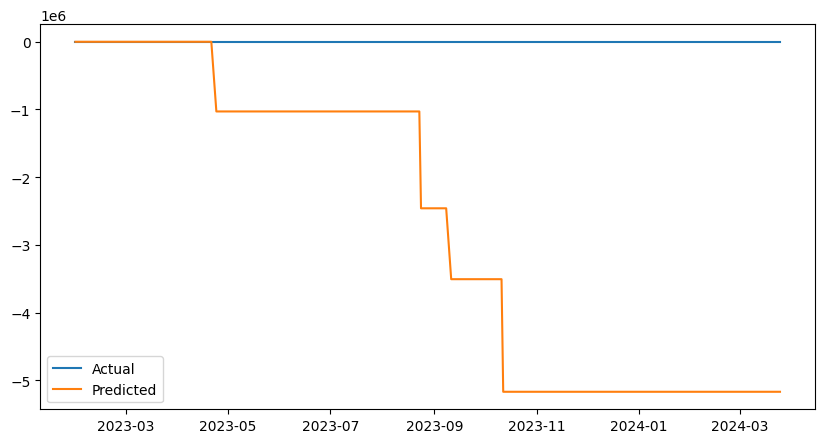

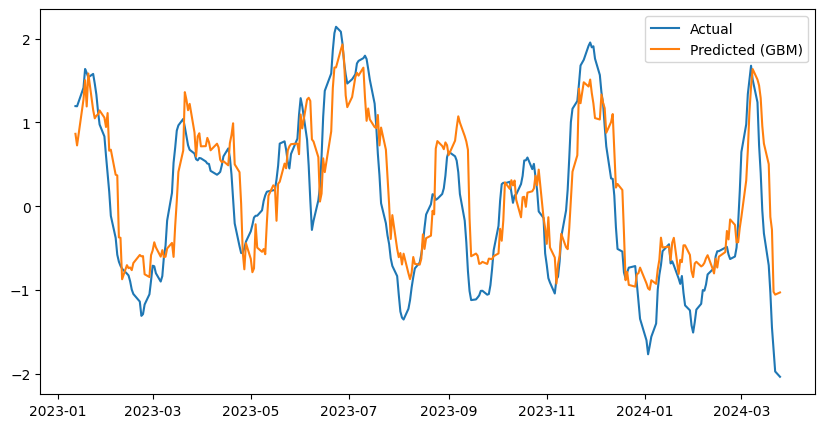

ValueError: All arrays must be of the same length

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def calculate_metrics(y_true, y_pred):
    metric_frame = {
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }
    print(f"\nR2: {metric_frame['r2']:.2f}, MAE: {metric_frame['mae']:.2f}, MAPE: {metric_frame['mape']*100:.2f}%")

# ---- Model Training ----
model_reg = LinearRegression()
model_reg.fit(X_train, y_train)

y_pred = model_reg.predict(X_test)

model_results = {}
model_results['Vanilla Regression'] = calculate_metrics(y_test, y_pred)


fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()

config_to_use = configurations[0]
display(config_to_use)
pair_df, X_train, y_train, X_test, y_test = build_configuration(
    config_to_use)
print(f"No. of features: {X_train.shape[1]}")

from sklearn.ensemble import GradientBoostingRegressor

# Train GBM model
model_gbm = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gbm.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gbm = model_gbm.predict(X_test)

# Calculate evaluation metrics
model_results['GBM'] = calculate_metrics(y_test, y_pred_gbm)

# Plot actual vs. predicted values
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(y_test.index, y_test, label="Actual")
ax.plot(y_test.index, y_pred_gbm, label="Predicted (GBM)")
ax.legend()
plt.show()


# get feature importance
feature_importance = model_reg.coef_
features = X_train.columns
feature_importance_df = pd.DataFrame({"feature": features, "importance": feature_importance})
feature_importance_df = feature_importance_df.sort_values("importance",
                                                          ascending=False)


### Single Config Setup

In [31]:
selected_config = {
    'PAIR_IDX': 15,
    'ADD_SENTIMENT_MA': True,
    'SPREAD_WINDOW': None,
    'MA_HIGH': 60,
    'MA_LOW': 5,
    'LOOK_BACK': 3,
    'DROP_COLS': []
}

# selected_config = configurations[0]
display(selected_config)
pair_df, X_train, y_train, X_test, y_test = build_configuration(selected_config)
print(f"No. of features: {X_train.shape[1]}")

{'PAIR_IDX': 15,
 'ADD_SENTIMENT_MA': True,
 'SPREAD_WINDOW': None,
 'MA_HIGH': 60,
 'MA_LOW': 5,
 'LOOK_BACK': 3,
 'DROP_COLS': []}


------Dataset Information------
Set      Size  Date Cutoff
-----  ------  -------------
Train     435  2023-01-30
Val       145  2023-08-28
Test      145  2023-08-28
No. of features: 334


### Single Config Training

In [7]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lightgbm: filename=lightgbm-4.3.0-py3-none-macosx_14_0_arm64.whl size=1417807 sha256=d9f6172ae0dc6a80295ad134c1e760f2ee7921e6a53f4296f5391f3232418292
  Stored in directory: /Users/zhongyihao/Library/Caches/pip/wheels/5f/b6/8e/2147c3932dcf4c69975fca6144cec78ef125bedd717ba975f3
Successfully built lightgbm



LinearRegression

R2: -8928024680777.93, MAE: 2686949.94, MAPE: 721657301.03%

GradientBoostingRegressor

R2: 0.81, MAE: 0.40, MAPE: 146.31%

LGBMRegressor

R2: 0.82, MAE: 0.38, MAPE: 146.82%

RandomForestRegressor

R2: 0.83, MAE: 0.37, MAPE: 152.00%

SVR

R2: -1.02, MAE: 1.30, MAPE: 359.15%

KNeighborsRegressor

R2: -0.32, MAE: 1.04, MAPE: 167.42%

LinearRegression

R2: -8928024680777.93, MAE: 2686949.94, MAPE: 721657301.03%


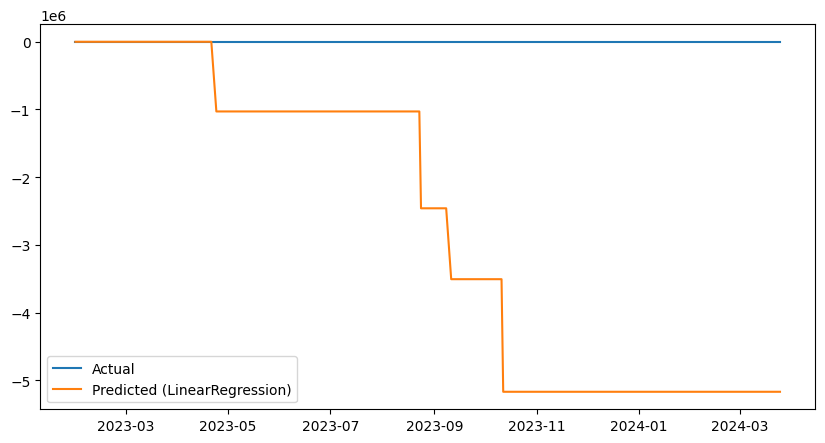


GradientBoostingRegressor

R2: 0.81, MAE: 0.40, MAPE: 146.31%


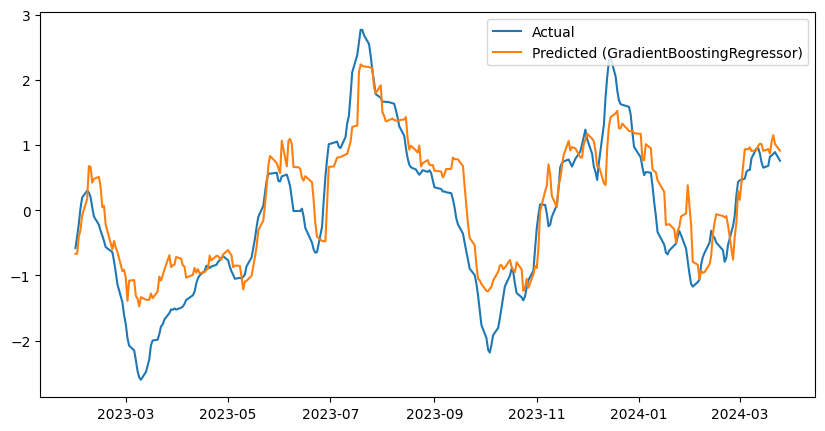

In [8]:
# ---- Model Training ----

from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')   
base_models = [
    LinearRegression(),
    GradientBoostingRegressor(random_state=42),
    LGBMRegressor(random_state=42, verbose=-1),
    # SGDRegressor(random_state=42),
    RandomForestRegressor(n_estimators=100, random_state=42),
    SVR(),
    KNeighborsRegressor(),
    
]

for model in base_models:
    y_pred = train(model, X_train, y_train, X_test, y_test, model_results, plot=False)


model_reg = LinearRegression()
train(model_reg, X_train, y_train, X_test, y_test, model_results, plot=True)


model_gbm = GradientBoostingRegressor(n_estimators=100, random_state=42)
train(model_gbm, X_train, y_train, X_test, y_test, model_results)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1629
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7544 
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6083
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5246
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3731 
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3801 
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3331
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2916 
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3225
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2297 
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2516
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2115
Epoch 13/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2137
Epoch 14/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2031
Epoch 15/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2219

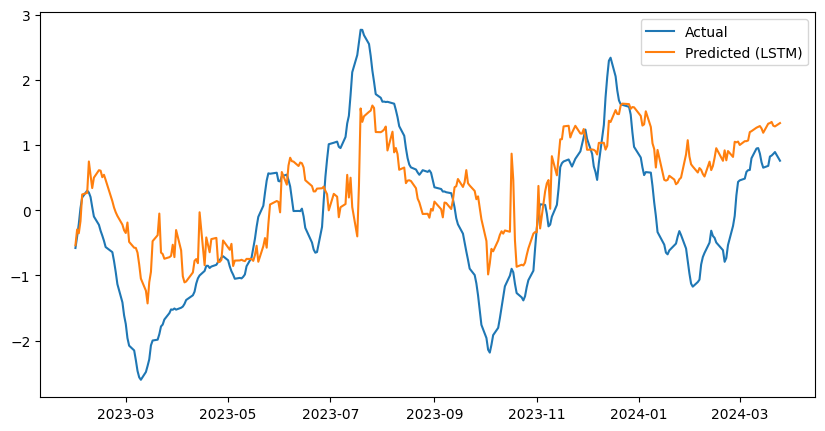

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
def calculate_padding(features, look_back):
    return (look_back - (features % look_back)) % look_back
LOOK_BACK = 3
padding_train = calculate_padding(X_train.shape[1], LOOK_BACK)
padding_test = calculate_padding(X_test.shape[1], LOOK_BACK)

# Pad both training and testing feature sets
X_train_padded = np.pad(X_train.values, ((0, 0), (0, padding_train)), 'constant', constant_values=0)
X_test_padded = np.pad(X_test.values, ((0, 0), (0, padding_test)), 'constant', constant_values=0)

# Reshape both sets for LSTM
X_train_lstm = X_train_padded.reshape((X_train.shape[0], LOOK_BACK, -1))
X_test_lstm = X_test_padded.reshape((X_test.shape[0], LOOK_BACK, -1))


# Build the LSTM model
model_lstm = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

# Fit the model
model_lstm.fit(X_train_lstm, y_train, epochs=200, verbose=1)

# Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

calculate_metrics(y_test, y_pred_lstm.flatten())




Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4308
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7374 
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5135 
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4674 
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3831
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3425
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3620
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2905
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3092
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2603
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2149
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2117
Epoch 13/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2107
Epoch 14/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2398
Epoch 15/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1859


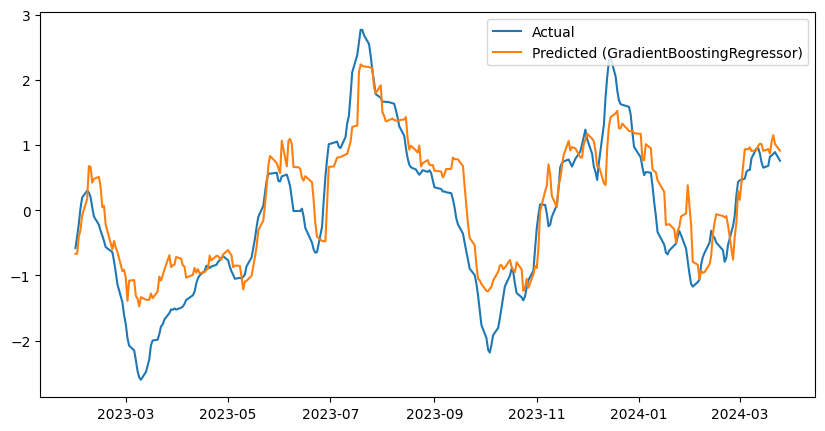

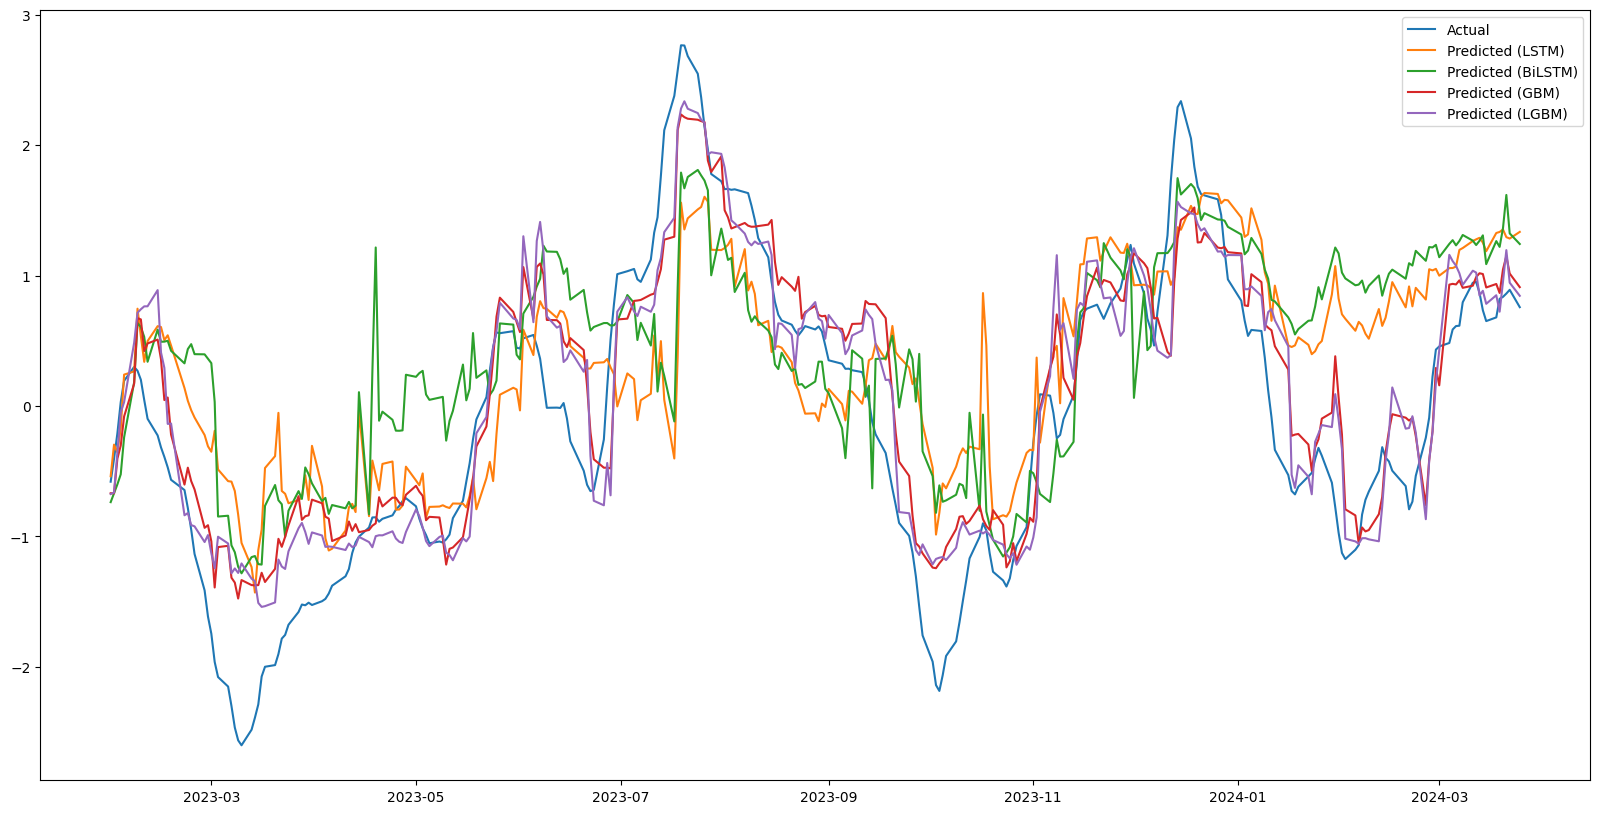

In [35]:
model_bilstm = Sequential([
        Bidirectional(LSTM(70, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(0.2),  # Dropout for regularizing and preventing overfitting
        Bidirectional(LSTM(50)),
        Dense(1)  # Output layer
    ])

model_bilstm.compile(optimizer='adam', loss='mse')

# Fit the model
model_bilstm.fit(X_train_lstm, y_train, epochs=200, verbose=1)

# Predict
y_pred_bilstm = model_bilstm.predict(X_test_lstm)

# Evaluate
calculate_metrics(y_test, y_pred_bilstm.flatten())

# Plot actual vs. predicted values



base_models = [
    LinearRegression(),
    GradientBoostingRegressor(random_state=42),
    LGBMRegressor(random_state=42, verbose=-1),
    # SGDRegressor(random_state=42),
    RandomForestRegressor(n_estimators=100, random_state=42),
    SVR(),
    KNeighborsRegressor(),
    
]
y_preds_dict = {}
for model in base_models:
    y_pred = train(model, X_train, y_train, X_test, y_test, model_results, plot=False)
    y_preds_dict[model.__class__.__name__] = y_pred

model_reg = LinearRegression()
train(model_reg, X_train, y_train, X_test, y_test, model_results, plot=False)


model_gbm = GradientBoostingRegressor(n_estimators=100, random_state=42)
train(model_gbm, X_train, y_train, X_test, y_test, model_results)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(y_test.index, y_test, label="Actual")
ax.plot(y_test.index, y_pred_lstm, label="Predicted (LSTM)")
ax.plot(y_test.index, y_pred_bilstm, label="Predicted (BiLSTM)")
#GradientBoostingRegressor
ax.plot(y_test.index, y_preds_dict['GradientBoostingRegressor'], label="Predicted (GBM)")
ax.plot(y_test.index, y_preds_dict['LGBMRegressor'], label="Predicted (LGBM)")

ax.legend()
plt.show()


## Grid Search Setup 

In [ ]:
%matplotlib inline 


MA_HIGH = [60]
MA_LOW = [1, 3, 10]
look_back = [1, 3, 5, 7]

for i in range(10):


    selected_config = {
        'PAIR_IDX': i,
        'ADD_SENTIMENT_MA': False,
        'SPREAD_WINDOW': None,
        'MA_HIGH': 60,
        'MA_LOW': 5,
        'LOOK_BACK': 3,
        'DROP_COLS': []
    }

    # selected_config = configurations[0]
    display(selected_config)
    pair_df, X_train, y_train, X_test, y_test = build_configuration(selected_config)
    print(f"No. of features: {X_train.shape[1]}")

    base_models = [
        LinearRegression(),
        GradientBoostingRegressor(random_state=42),
        LGBMRegressor(random_state=42, verbose=-1),
        RandomForestRegressor(n_estimators=100, random_state=42),
        SVR(),
        KNeighborsRegressor(),
    ]

    for model in base_models:
        train(model, X_train, y_train, X_test, y_test, model_results, plot=True)


## Disregard Below

In [131]:
import tsfresh

print(f"Original Shape: {X_train.shape}")
X_sel = tsfresh.select_features(X_train, y_train)

print(f"Shape after feature selection: {X_sel.shape}")

relevance_table = tsfresh.feature_selection.relevance.calculate_relevance_table(
    X_train, y_train)


Original Shape: (497, 268)
Shape after feature selection: (497, 148)


/Users/darien/miniforge3/envs/tradingScratch310/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/darien/miniforge3/envs/tradingScratch310/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/darien/miniforge3/envs/tradingScratch310/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This w

In [132]:
X_sel_train = X_train[X_sel.columns]
X_sel_test = X_test[X_sel.columns]

for model in base_models:
    train(model, X_sel_train, y_train, X_sel_test, y_test, model_results, plot=False)


LinearRegression

R2: 0.72, MAE: 0.56, MAPE: 77.49%

GradientBoostingRegressor

R2: 0.82, MAE: 0.41, MAPE: 61.61%

LGBMRegressor

R2: 0.81, MAE: 0.42, MAPE: 65.46%

RandomForestRegressor

R2: 0.82, MAE: 0.39, MAPE: 64.58%

SVR

R2: 0.53, MAE: 0.69, MAPE: 79.43%

KNeighborsRegressor

R2: 0.56, MAE: 0.66, MAPE: 91.19%


In [17]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd

# Initialize H2O cluster
h2o.init()

# Load the dataset


# Apply feature selection and evaluate models
def feature_selection_evaluation(df, config):
    pair_df = build_configuration(df, config)
    
    # Assuming 'target' is the column to predict
    X_cols = [col for col in pair_df.columns if col != 'target']
    X = pair_df[X_cols]
    y = pair_df['target']
    
    # Convert Pandas DataFrame to H2O Frame
    hf = h2o.H2OFrame(pd.concat([X, y], axis=1))
    
    # Splitting the data into train and test
    train, test = hf.split_frame([0.8], seed=42)
    
    # Model training and evaluation using AutoML
    aml = H2OAutoML(max_models=10, seed=1)
    aml.train(y='target', training_frame=train)
    
    # Model performance
    lb = aml.leaderboard
    print(lb)
    
    # Best model
    best_model = aml.leader
    performance = best_model.model_performance(test)
    print(performance)

# Iterate over different configurations
for config in configurations:
    print(f"Evaluating with config: {config}")
    feature_selection_evaluation(df, config)

# Shutdown H2O cluster
h2o.shutdown()

,High_S1,Low_S1,Open_S1,Volume_S1,Adj Close_S1,P_S1,R1_S1,R2_S1,R3_S1,S1_S1,...,others_dlr_S2,others_cr_S2,news_pos_sentiment_count_S1,news_sentiment_daily_avg_S1,twitter_pos_sentiment_count_S1,news_sentiment_daily_avg_S2,twitter_pos_sentiment_count_S2,news_pos_sentiment_count_S2,spread,zscore_spread
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-30,335.75,328.85,329.41,2717270.0,332.01,332.203333,334.839133,336.467533,339.103333,329.567533,...,-1.141262,5.407839,2.0,-0.3548,5.0,0.0000,13.0,0.0,-63.225426,-0.407533
2021-03-31,332.65,325.44,330.23,2624540.0,327.00,328.363333,331.117553,332.819113,335.573333,325.609113,...,0.625326,6.069047,2.0,-0.0090,4.0,0.0000,12.0,0.0,-46.265097,-0.272490
2021-04-01,329.66,324.16,324.30,2658951.0,327.64,327.153333,329.254333,330.552333,332.653333,325.052333,...,1.692582,7.879632,2.0,0.0005,6.0,0.0000,18.0,0.0,-34.961287,-0.100009
2021-04-05,332.85,323.05,332.85,3234998.0,323.54,326.480000,330.223600,332.536400,336.280000,322.736400,...,2.216940,10.297966,0.0,0.0000,1.0,0.0000,4.0,0.0,-7.737883,0.033402
2021-04-06,328.54,324.00,324.49,1801975.0,327.06,326.533333,328.267613,329.339053,331.073333,324.799053,...,-0.295070,9.972989,1.0,-0.0007,11.0,0.0000,6.0,0.0,-18.661927,0.119335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22,416.76,405.78,414.40,2190278.0,406.82,409.786667,413.981027,416.572307,420.766667,405.592307,...,-2.067397,16.039222,14.0,0.2668,29.0,0.0084,20.0,4.0,-170.728330,-1.024253
2024-03-25,410.46,403.86,406.87,1683977.0,404.94,406.420000,408.941200,410.498800,413.020000,403.898800,...,-1.050563,14.826538,2.0,0.0087,15.0,-0.0060,11.0,0.0,-174.747648,-1.442855
2024-03-26,409.33,404.52,406.09,1406974.0,406.18,406.676667,408.514087,409.649247,411.486667,404.839247,...,0.487654,15.387862,0.0,-0.0096,18.0,-0.0008,25.0,0.0,-173.792140,-1.707300
